<a href="https://colab.research.google.com/github/NataliaBlueCloud/Inband_telemetry_design/blob/main/Cochrams_ofc_example_3paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("simmer")
install.packages("SciViews")
install.packages("igraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(simmer)
library(SciViews)
library(igraph)
library(readxl)
library(ggplot2)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [3]:
library("googledrive")
if (file.exists("/usr/local/lib/python3.10/dist-packages/google/colab/_ipython.py")){
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.25.0 (2022-06-12 02:20:02 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following object is masked from ‘package:igraph’:

    hierarchy


The following object is masked from ‘package:simmer’:

    clone


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.2 (2022-11-11 22:00:03 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following objects are masked from ‘package:simmer’:

    reset, wrap


The fo

In [4]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=ae635f2eea28c61d5b396369921ce6a3&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbWpMMUVSS0pjUGxkLUdiZTBDYWZHZHh0QzlISHFMVFA3N3R4UDl4a3VQVTc4bkNpZUFLWkc0WWVFbXBZQ1lCUSIsInN0YXRlIjoiYWU2MzVmMmVlYTI4YzYxZDViMzk2MzY5OTIxY2U2YTMifQ==


In [7]:

drive_download("r_traffic_simulation/func/igraph_function_base.R")
drive_download("r_traffic_simulation/func/igraph_functions.R")
drive_download("r_traffic_simulation/func/general_function_base.R")


File downloaded:

• igraph_function_base.R <id: 1jwogeGEqQc27cQAu8fiA1mF-KI9C41pm>

Saved locally as:

• igraph_function_base.R

File downloaded:

• igraph_functions.R <id: 1Vyg5nvBWPkMzuajVkyFELct6G1qmjMdP>

Saved locally as:

• igraph_functions.R

File downloaded:

• general_function_base.R <id: 18dycCYyQDWXi1dDVj22EoJWkeYQy-9qg>

Saved locally as:

• general_function_base.R



In [8]:
drive_download("r_traffic_simulation/input_files/Metro_topology_full_Milano.xlsx")


File downloaded:

• Metro_topology_full_Milano.xlsx <id: 1qf9aV3AICULgJEx2D98nInZwKnW8D7dn>

Saved locally as:

• Metro_topology_full_Milano.xlsx



In [9]:
source("igraph_function_base.R")
source("igraph_functions.R")
source("general_function_base.R")

In [10]:
file_name <- "Metro_topology_full_Milano.xlsx"

In [11]:
nodes_info <- read_excel(file_name, sheet = 1)
links_info <- read_excel(file_name, sheet = 2)


#M/M/1 model

##Input data

In [12]:
N = 1250 #packet size (B)
CapacityGbps = 10 #Gbps

In [13]:
create_graph_object <- function(links_info, nodes_info, CapacityGbps,  N = 1250) {
  g <- graph.data.frame(links_info, directed = TRUE, vertices = nodes_info)
  E(g)$capacityGbps <- CapacityGbps
  E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N)
  E(g)$Distance <- E(g)$distanceKm*4
  E(g)$Definition <- paste0(get.edgelist(g)[,1],"->",get.edgelist(g)[,2])

  return(g)
}


g <- create_graph_object(links_info, nodes_info, CapacityGbps,  N)



In [14]:
################################plot graph

V(g)$color <- "grey"
V(g)$node_type <- "Access CO"
V(g)$color[47] <- "yellow" #source node
V(g)$node_type[47] <- "Access CO (source)"
V(g)$node_type[10] <- "Access CO (source)"
V(g)$node_type[19] <- "Access CO (source)"


NCOs <- V(g)[c(c(9:20), c(40:44))] #RCOs
#NCOs <- V(g)[c(c(1:8),c(21:24))]
V(g)$Node_Type <- "LCO"
V(g)$Node_Type[NCOs] <- "NCO"
LCOs <- V(g)[V(g)$Node_Type == "LCO"]

V(g)$color[NCOs] <- "green" # National COs
E(g)$color <- "gray"
V(g)$color[c(10,19)] <- "red"

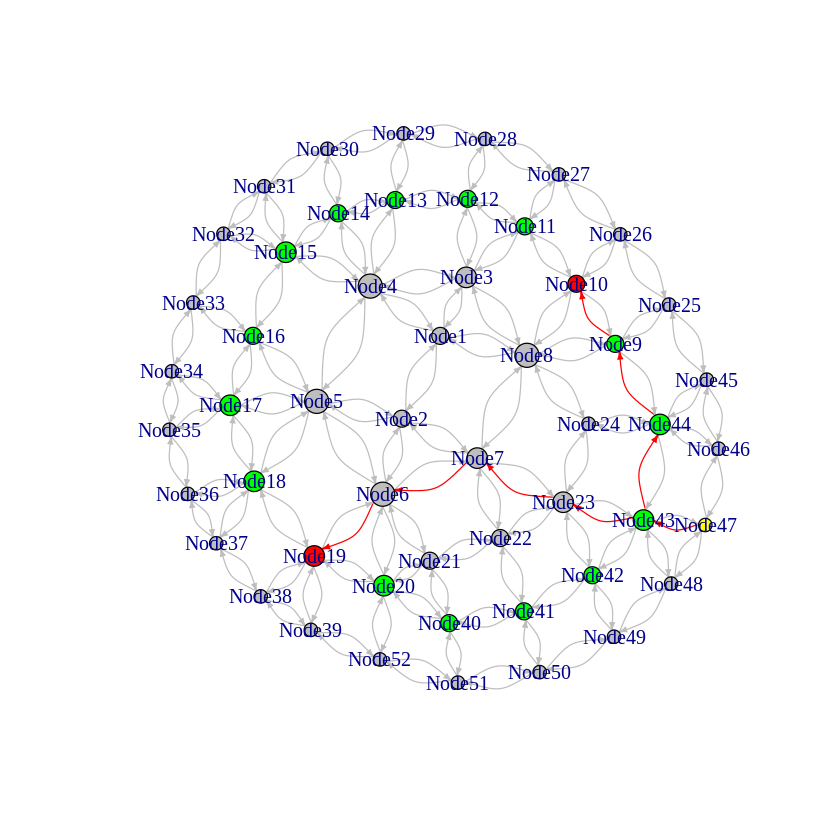

In [15]:

path_1 <- shortest_paths(g, 47, 10, weights = NULL, output = "both", algorithm = c("automatic"))
path_1 <- E(g)[path_1[["epath"]][[1]]]
E(g)$color[path_1] <- "red"

path_2 <- shortest_paths(g, 47, 19, weights = NULL, output = "both", algorithm = c("automatic"))
path_2 <- E(g)[path_2[["epath"]][[1]]]
E(g)$color[path_2] <- "red"

deg <- degree(g, mode="all")
V(g)$size <- 1 + deg*1.3/2
l <- layout.auto(g)
edge_indices <- c(path_1, path_2)

E(g)$arrow_sizes <- 0.3
E(g)$arrow_sizes[edge_indices] <- 0.7
plot(g, edge.arrow.size = E(g)$arrow_sizes, vertex.label = V(g)$name, edge.curved = 0.5, layout = l)


In [16]:
E(g)$Load <- runif(length(E(g)), 0.1, 0.8)

There are 3 paths:

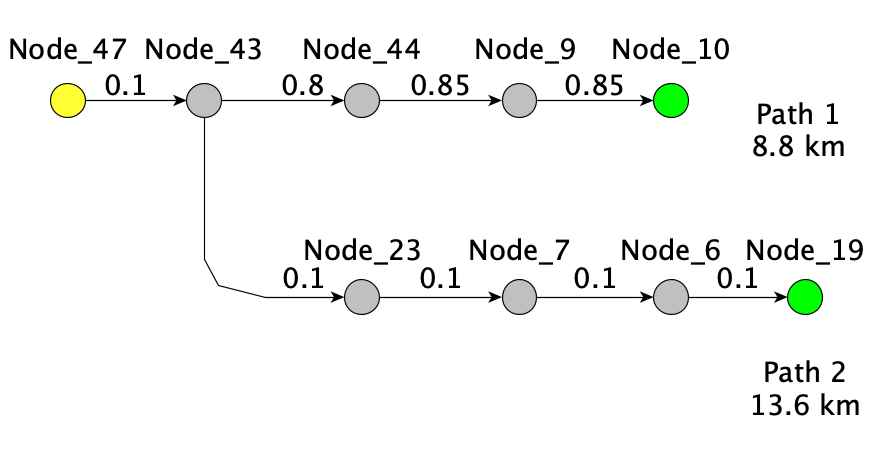

In [17]:
Load_p1 <- c(0.1,0.8,0.85,0.85)
Load_p2 <- c(0.1,0.1,0.1,0.1,0.1)



In [18]:
E(g)$Load[path_1] <- Load_p1
E(g)$Load[path_2] <- Load_p2


In [19]:
print(paste("Distance path 1",sum(E(g)$Distance[path_1]), "km"))
print(paste("Distance path 2",sum(E(g)$Distance[path_2]), "km"))

[1] "Distance path 1 8.8 km"
[1] "Distance path 2 13.6 km"


## Queuing and propagation delays

In [20]:
############################################################
########################load and delays calculations MM1

traffic_delays_calc <- function(g) {
  E(g)$Traffic <- E(g)$Capacity*E(g)$Load

  E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Ni/E(g)$Traffic)
  E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance
  return(g)
}
g <- traffic_delays_calc(g)

In [21]:
rexp_for_pop <- function(rate){
  pop_number = 50000
  return(rexp(n=pop_number,rate))
}


##Simulation of 50k population

###Path 1

In [22]:
x <- 1/E(g)$Queue_Delay[path_1]
traffic_path_1 <-  lapply(x, rexp_for_pop)
path1_delays <- Reduce("+", traffic_path_1) + sum(E(g)$Prop_Delay[path_1])
path1_delays_us <- path1_delays*1e6# in uprint(path1_delays_us[1:10])
mean(path1_delays_us)

[1] 63.4859

###Path 2

In [23]:
x <- 1/E(g)$Queue_Delay[path_2]
traffic_path_2 <-  lapply(x, rexp_for_pop)
path2_delays <- Reduce("+", traffic_path_2) + sum(E(g)$Prop_Delay[path_2])
path2_delays_us <- path2_delays*1e6# in uprint(path1_delays_us[1:10])print(path2_delays_us[1:10])
mean(path2_delays_us)

[1] 73.56285

###PDF function of delays

In [24]:
threshold_us <- 82

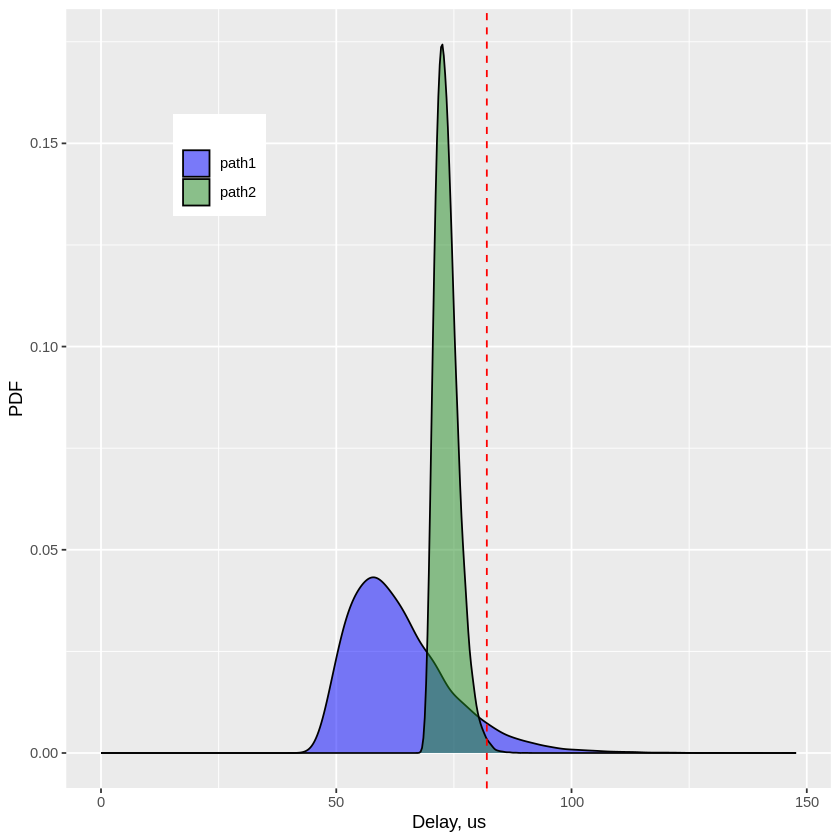

In [61]:
df <- data.frame(delay_value = c(path1_delays,path2_delays),
                 path_number = c(rep("path1",length(path1_delays)),rep("path2",length(path2_delays))))

p1 <- ggplot(data=df, aes(x=delay_value*1e6, group=path_number, fill=path_number)) +
  geom_density(adjust=1.5, alpha=.5) + xlim(0, max(path1_delays*1e6)) + xlab("Delay, us") + scale_fill_manual(values = c("blue" , "forestgreen"), name = "" ) +
  geom_vline(xintercept = threshold_us, colour = "red",linetype = "dashed") + ylab("PDF")

p1 +  theme(legend.position = c(0.2, 0.8))

##Results

In [26]:
n_exp <- 10000

In [27]:
table_to_df <- function(path_delays, threshold_us){
  df_p <- as.data.frame(table(path_delays*1e6<threshold_us, useNA = "always"))
  df_p$Var1 <- as.logical(df_p$Var1)
  df_p$Var1[2] = ifelse(df_p$Var1[1] == 1, 0, 1)
  return(df_p)
}

In [46]:
calc_results <- function(traffic_path_1, traffic_path_2, g, threshold_us,n_samples, n_exp)
{
  results <- c()
  percent_below_thr_p1 <- c()
  percent_below_thr_p2 <- c()

  for (exp in 1:n_exp)
  {
    path1_delays = sum(E(g)$Prop_Delay[path_1]) +
      sample(traffic_path_1[[1]], size=n_samples, replace=F) +
      sample(traffic_path_1[[2]], size=n_samples, replace=F) +
      sample(traffic_path_1[[3]], size=n_samples, replace=F) +
      sample(traffic_path_1[[4]], size=n_samples, replace=F) # in s
    path2_delays = sum(E(g)$Prop_Delay[path_2]) +
      sample(traffic_path_2[[1]], size=n_samples, replace=F) +
      sample(traffic_path_2[[2]], size=n_samples, replace=F) +
      sample(traffic_path_2[[3]], size=n_samples, replace=F) +
      sample(traffic_path_2[[4]], size=n_samples, replace=F) +
      sample(traffic_path_2[[5]], size=n_samples, replace=F) # in s

    percent_below_thr_p1[exp] <- length(path1_delays[path1_delays*1e6 < threshold_us])/length(path1_delays)*100
    percent_below_thr_p2[exp] <- length(path2_delays[path2_delays*1e6 < threshold_us])/length(path2_delays)*100

    df_p1 <- table_to_df(path1_delays, threshold_us)
    df_p1 <- df_p1[order(df_p1$Var1),]
    df_p2 <- table_to_df(path2_delays, threshold_us)
    df_p2 <- df_p2[order(df_p2$Var1),]
    table_res <-c(df_p1$Freq[2],df_p2$Freq[2])

    max_indexes <- as.vector(which(table_res == max(table_res)))
    max_index <- ifelse(length(max_indexes) > 1, sample(max_indexes, 1), max_indexes)
    results[exp] <- max_index
  }
  print("In a single experiment:")
  print("% below threshold - ")
  cat("path1", percent_below_thr_p1[1],"\n" )
  cat("path2", percent_below_thr_p2[1],"\n" )
  print("Av delay, us -")
  cat("path1", mean(path1_delays)*1e6,"\n" )
  cat("path2", mean(path2_delays)*1e6,"\n" )
  return(list(results,percent_below_thr_p1,percent_below_thr_p2))
}

###Sample sizes

5 packets

In [47]:
c(results_5p, percent_below_thr_p1_5p, percent_below_thr_p2_5p ) := calc_results(traffic_path_1, traffic_path_2, g, threshold_us, n_samples = 5, n_exp)
cat("percentage path 1 is chosen", length(results_5p[results_5p == 1])/length(results_5p)*100, "\n")# percentage path 1 is chosen
cat("percentage path 2 is chosen", length(results_5p[results_5p == 2])/length(results_5p)*100, "\n") # percentage path 2 is chosen

[1] "In a single experiment:"
[1] "% below threshold - "
path1 100 
path2 100 
[1] "Av delay, us -"
path1 57.4392 
path2 73.3537 
percentage path 1 is chosen 36.61 
percentage path 2 is chosen 63.39 


10 packets

In [48]:
c(results_10p, percent_below_thr_p1_10p, percent_below_thr_p2_10p ) := calc_results(traffic_path_1, traffic_path_2, g, threshold_us, n_samples = 10, n_exp)
cat("percentage path 1 is chosen", length(results_10p[results_10p == 1])/length(results_10p)*100, "\n")# percentage path 1 is chosen
cat("percentage path 2 is chosen", length(results_10p[results_10p == 2])/length(results_10p)*100, "\n")# percentage path 2 is chosen

[1] "In a single experiment:"
[1] "% below threshold - "
path1 90 
path2 100 
[1] "Av delay, us -"
path1 65.57961 
path2 72.95749 
percentage path 1 is chosen 28.04 
percentage path 2 is chosen 71.96 


50 packets

In [49]:
c(results_50p, percent_below_thr_p1_50p, percent_below_thr_p2_50p ) := calc_results(traffic_path_1, traffic_path_2, g, threshold_us, n_samples = 50, n_exp)
cat("percentage path 1 is chosen", length(results_50p[results_50p == 1])/length(results_50p)*10, "\n")# percentage path 1 is chosen
cat("percentage path 2 is chosen", length(results_50p[results_50p == 2])/length(results_50p)*100, "\n")# percentage path 2 is chosen

[1] "In a single experiment:"
[1] "% below threshold - "
path1 90 
path2 100 
[1] "Av delay, us -"
path1 62.59421 
path2 73.22894 
percentage path 1 is chosen 0.431 
percentage path 2 is chosen 95.69 


100 packets

In [50]:
c(results_100p, percent_below_thr_p1_100p, percent_below_thr_p2_100p ) := calc_results(traffic_path_1, traffic_path_2, g, threshold_us, n_samples = 100, n_exp)
cat("percentage path 1 is chosen", length(results_100p[results_100p == 1])/length(results_100p)*100, "\n")# percentage path 1 is chosen
cat("percentage path 2 is chosen", length(results_100p[results_100p == 2])/length(results_100p)*100, "\n")# percentage path 2 is chosen

[1] "In a single experiment:"
[1] "% below threshold - "
path1 95 
path2 100 
[1] "Av delay, us -"
path1 63.76975 
path2 73.80107 
percentage path 1 is chosen 0.71 
percentage path 2 is chosen 99.29 


400 packets

In [51]:
c(results_400p, percent_below_thr_p1_400p, percent_below_thr_p2_400p ) := calc_results(traffic_path_1, traffic_path_2, g, threshold_us, n_samples = 400, n_exp)
cat("percentage path 1 is chosen", length(results_400p[results_400p == 1])/length(results_400p)*100, "\n")# percentage path 1 is chosen
cat("percentage path 2 is chosen", length(results_400p[results_400p == 2])/length(results_400p)*100, "\n")# percentage path 2 is chosen

[1] "In a single experiment:"
[1] "% below threshold - "
path1 94 
path2 99.25 
[1] "Av delay, us -"
path1 63.69054 
path2 73.61126 
percentage path 1 is chosen 0 
percentage path 2 is chosen 100 


In [52]:
c(results_50kp, percent_below_thr_p1_50kp, percent_below_thr_p2_50kp ) := calc_results(traffic_path_1, traffic_path_2, g, threshold_us, n_samples = 50000, n_exp = 1)


[1] "In a single experiment:"
[1] "% below threshold - "
path1 93.584 
path2 99.514 
[1] "Av delay, us -"
path1 63.4859 
path2 73.56285 


##Boxplots

The percentage of times where each path is chosen as best in "n_exp" experiments for the threshold of 82 μs

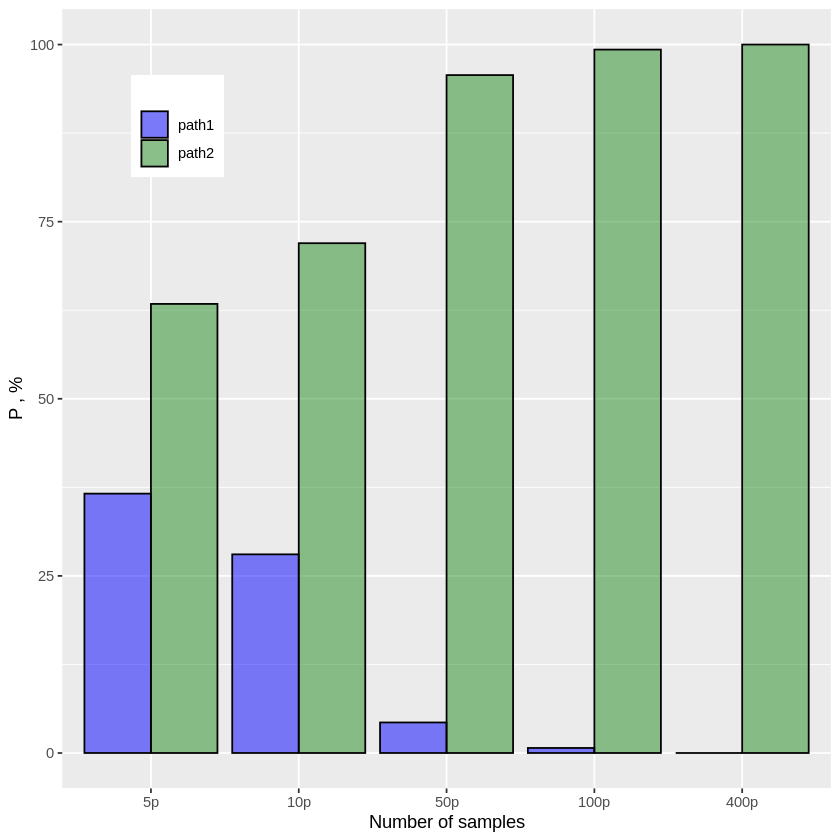

In [54]:
data=data.frame(value = c(length(results_5p[results_5p == 1])*100/n_exp, length(results_5p[results_5p == 2])*100/n_exp,
                          length(results_10p[results_10p == 1])*100/n_exp, length(results_10p[results_10p == 2])*100/n_exp,
                          length(results_50p[results_50p == 1])*100/n_exp, length(results_50p[results_50p == 2])*100/n_exp,
                          length(results_100p[results_100p == 1])*100/n_exp, length(results_100p[results_100p == 2])*100/n_exp,
                          length(results_400p[results_400p == 1])*100/n_exp,length(results_400p[results_400p == 2])*100/n_exp
                          ),
                path_number = c("path1","path2",
                                "path1","path2",
                                "path1","path2",
                                "path1","path2",
                                "path1","path2"),
                packet_number = c(
                  rep("5p",2),
                  rep("10p",2),rep("50p",2),rep("100p",2),rep("400p",2)
                  ))

data$packet_number <- factor(data$packet_number , levels=c(
  "5p", "10p", "50p", "100p", "400p"
  ))

# grouped boxplot
ggplot(data, aes(x=packet_number, y=value, fill=path_number)) +
  geom_bar(stat = "identity",position=position_dodge(), size = 0.5, color = "black",alpha = 0.5) +
  scale_fill_manual(values = c("blue" , "forestgreen"), name = "" )  + ylab("P , %") +
  xlab("Number of samples")  +  theme(legend.position = c(0.15, 0.85))
